# Additional figures (hmf metric boxplots by aquifer & huc2, event frequency-duration curves)

In [106]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondris\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

### Import national metrics

In [107]:
# All gages - National metrics dfs
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/National_Metrics_50_95.xlsx'    
}

dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}

In [108]:
# Converts site_no to strings
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles: 
        # Assuming df is your DataFrame and 'column_name' is the name of the column with numbers
        dfs_metrics[f'{date_range}_{percentile}']['site_no'] = dfs_metrics[f'{date_range}_{percentile}']['site_no'].astype(str)  # Convert numbers to strings

        # Add leading '0' to numbers with 7 digits
        dfs_metrics[f'{date_range}_{percentile}']['site_no'] = dfs_metrics[f'{date_range}_{percentile}']['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)

In [112]:
dfs_metrics['30_90'].loc[dfs_metrics['30_90']['valid'] == True]

site_no analyze_start analyze_end  analyze_range  quantile  valid  \
1     02342500    1990-10-01  2020-09-30             30       0.9   True   
2     02361000    1990-10-01  2020-09-30             30       0.9   True   
4     02363000    1990-10-01  2020-09-30             30       0.9   True   
6     02369800    1990-10-01  2020-09-30             30       0.9   True   
7     02371500    1990-10-01  2020-09-30             30       0.9   True   
...        ...           ...         ...            ...       ...    ...   
7894  09211200    1990-10-01  2020-09-30             30       0.9   True   
7897  09217000    1990-10-01  2020-09-30             30       0.9   True   
7901  09223000    1990-10-01  2020-09-30             30       0.9   True   
7902  09224700    1990-10-01  2020-09-30             30       0.9   True   
7912  13018300    1990-10-01  2020-09-30             30       0.9   True   

      missing_data%  threshold  hmf_years  annual_hmf  ...  dec_lat_va  \
1               0.0     850.30         30    0.109441  ...   32.316815   
2               0.0    1770.00         30    0.155185  ...   31.342949   
4               0.0    1300.00         30    0.114796  ...   31.594887   
6               0.0     261.00         29    0.027931  ...   31.027680   
7               0.0    1380.00         30    0.117638  ...   31.573495   
...             ...        ...        ...         ...  ...         ...   
7894            0.0    2410.00         22    0.330262  ...   42.020972   
7897            0.0    2440.00         22    0.332683  ...   41.516354   
7901            0.0     255.00         29    0.021793  ...   42.110889   
7902            0.0     657.30         26    0.075912  ...   41.546072   
7912            0.0      29.93         28    0.002070  ...   43.452153   

      dec_long_va  data_start   data_end  total_record  state  huc2_code  \
1      -85.014931  1946-10-01 2020-09-30          74.0     AL          3   
2      -85.610491  1921-12-01 2020-09-30          98.8     AL          3   
4      -85.782997  1938-10-01 2020-09-30          82.0     AL          3   
6      -86.709957  1967-10-01 2020-09-30          53.0     AL          3   
7      -86.251623  1937-10-01 2020-09-30          83.0     AL          3   
...           ...         ...        ...           ...    ...        ...   
7894  -110.049806  1963-12-01 2020-09-30          56.8     WY         14   
7897  -109.449023  1951-10-01 2020-09-30          69.0     WY         14   
7901  -110.709417  1952-10-01 2020-09-30          68.0     WY         14   
7902  -109.693475  1962-06-01 2020-09-30          58.3     WY         14   
7912  -110.704091  1962-07-01 2020-09-30          58.3     WY         17   

      huc4_code                                  within_aq  HCDN_2009  
1           313  Southeastern Coastal Plain aquifer system      False  
2           314  Southeastern Coastal Plain aquifer system      False  
4           314  Southeastern Coastal Plain aquifer system      False  
6           314            Coastal lowlands aquifer system      False  
7           314  Southeastern Coastal Plain aquifer system      False  
...         ...                                        ...        ...  
7894       1404                                        NaN      False  
7897       1404                                        NaN      False  
7901       1404                                        NaN      False  
7902       1404                                        NaN      False  
7912       1704                                        NaN       True  

[4242 rows x 40 columns]

In [4]:
# Valid gages - National metrics dfs
dfs_valid = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        dfs_valid[f'{date_range}_{percentile}'] = dfs_metrics[f'{date_range}_{percentile}'][dfs_metrics[f'{date_range}_{percentile}']['valid'] == True]

In [173]:
# Outlet gages by aquifer
br_outlet_gages = ['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
cc_outlet_gages = ['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
cv_outlet_gages = ['11303500', '11447650']
cl_outlet_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500',
      '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
fl_outlet_gages = ['02368000', '02365500', '02358000', '02320500', '02313230']
hp_outlet_gages = ['06465500', '06805500', '06853500', '06884000', '07144550', '07158000', '07237500', '07228000', '07297910', '08123850']
mr_outlet_gages = ['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
na_outlet_gages = ['02105769', '02089500', '02091500', '02083500',  '02085000', '02052000', '02047000', '02049500',  '02041650', '02037500', '01668000', 
      '01673000',  '01646500', '01578310', '01474500',  '01463500']
pn_outlet_gages = ['11039800', '12200500', '12040500', '14211720',  '14372300']
sr_outlet_gages = ['13269000']
cp_outlet_gages = ['13342500', '13334300', '12472800', '12510500', '13351000', '14033500', '14048000', '14103000']
rg_outlet_gages = ['08319000']
me_outlet_gages = ['07029500', '07268000', '07283000', '07285500', '07289350', '02482550', '02477000', '02469761', '02428400', 
                   '07362000', '07363500', '07348700']
co_outlet_gages = ['05378500', '05407000', '05437500', '04082400']
sc_outlet_gages = ['02130561', '02171500', '02197000', '02223248', '02343801', '02467000']
bi_outlet_gages = ['02287497', '02289060', '02290765', '02290769']
et_outlet_gages = ['07337000', '08062700', '08159200', '08168500']
rm_outlet_gages = ['12389000', '06066500', '13302500']
pb_outlet_gages = ['02341475', '02339500', '02347500', '02213000', '02223000', '02197000', '02169500', 
'02148000', '02130561', '02102500', '02089000', '02083500' ,'02080500', '01646500', '01578310']
sa_outlet_gages = ['02359170', '02243960', '02296750', '02292900', '02226000', '02202500', '02198500', '02175000', '02171645']
vr_outlet_gages = ['02388500', '02397000', '03513000', '03455000', '03168000', '02019500', '01638500', '01570500']
sd_outlet_gages = ['05465500', '05420500', '05527500', '03335500']
pnb_outlet_gages = ['13087995', '12395500']
wl_outlet_gages = ['14211720']
lc_outlet_gages = ['05476750', '05479000', '05482300', '05483450', '06602020', '06606600', '06607200',
       '06809210', '06486000', '06601200', '06864500', '06865500', '06868200', '06869500',
       '06876700', '06884025', '06884200', '05061500', '05304500', '05313500', '05317000',
       '05476000', '06078200', '06090300', '06200000', '06601000', '06803000', '06803500',
       '06803510', '06803530', '06804000', '06881000', '05085000', '06395000', '06400000',
       '06402500', '06406000', '06414000', '06430500', '06433000', '06436000', '06436190',
       '06429997', '06279500', '06634620']

outlet_gages_dict_10 = {
    'br': br_outlet_gages, 
    'cc': cc_outlet_gages,
    'cv': cv_outlet_gages,
    'cl': cl_outlet_gages,
    'fl': fl_outlet_gages,
    'hp': hp_outlet_gages,
    'mr': mr_outlet_gages,
    'na': na_outlet_gages,
    'pn': pn_outlet_gages,
    'sr': sr_outlet_gages
}

outlet_gages_dict_25 = {
    'br': br_outlet_gages, 
    'cc': cc_outlet_gages,
    'cv': cv_outlet_gages,
    'cl': cl_outlet_gages,
    'fl': fl_outlet_gages,
    'hp': hp_outlet_gages,
    'mr': mr_outlet_gages,
    'na': na_outlet_gages,
    'pn': pn_outlet_gages,
    'sr': sr_outlet_gages,
    'cp': cp_outlet_gages,
    'rg': rg_outlet_gages,
    'me': me_outlet_gages,
    'co': co_outlet_gages,
    'sc': sc_outlet_gages,
    'bi': bi_outlet_gages,
    'et': et_outlet_gages,
    'rm': rm_outlet_gages,
    'pb': pb_outlet_gages,
    'sa': sa_outlet_gages,
    'vr': vr_outlet_gages,
    'sd': sd_outlet_gages,
    'pnb': pnb_outlet_gages,
    'wl': wl_outlet_gages,
    'lc': lc_outlet_gages}

aq_names_10 = {'hp': 'High Plains aquifer',
                'mr': 'Mississippi River Valley alluvial aquifer',
                'cv': 'Central Valley aquifer system',
                'br': 'Basin and Range basin-fill aquifers',
                'fl': 'Floridan aquifer system',
                'sr': 'Snake River Plain basaltic-rock aquifers',
                'cl': 'Coastal lowlands aquifer system',
                'cc': 'California Coastal Basin aquifers', 
                'pn': 'Pacific Northwest basin-fill aquifers',
                'na': 'Northern Atlantic Coastal Plain aquifer system'}

aq_names_25 = {'hp': 'High Plains aquifer',
                'mr': 'Mississippi River Valley alluvial aquifer',
                'cv': 'Central Valley aquifer system',
                'br': 'Basin and Range basin-fill aquifers',
                'fl': 'Floridan aquifer system',
                'sr': 'Snake River Plain basaltic-rock aquifers',
                'cl': 'Coastal lowlands aquifer system',
                'cc': 'California Coastal Basin aquifers', 
                'pn': 'Pacific Northwest basin-fill aquifers',
                'na': 'Northern Atlantic Coastal Plain aquifer system',
                'cp': 'Columbia Plateau basaltic-rock aquifers',
                'rg': 'Rio Grande aquifer system',
                'me': 'Mississippi embayment aquifer system',
                'co': 'Cambrian-Ordovician aquifer system',
                'sc': 'Southeastern Coastal Plain aquifer system',
                'bi': 'Biscayne aquifer',
                'et': 'Edwards-Trinity aquifer system',
                'rm': 'Northern Rocky Mountains Intermontane Basins aquifer system',
                'pb': 'Piedmont and Blue Ridge crystalline-rock aquifers',
                'sa': 'Surficial aquifer system',
                'vr': 'Valley and Ridge aquifers',
                'sd': 'Silurian-Devonian aquifers',
                'pnb': 'Pacific Northwest basaltic-rock aquifers',
                'wl': 'Willamette Lowland basin-fill aquifers',
                'lc': 'Lower Cretaceous aquifers'
              }

aq_codes_10 = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na']

aq_codes_25 = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na',
              'cp', 'rg', 'me', 'co', 'sc', 'bi', 'et', 'rm', 'pb', 'sa',
              'vr', 'sd', 'pnb', 'wl', 'lc']

selected_aq_list_7 = ['High Plains aquifer',
            'Mississippi River Valley alluvial aquifer',
            'Central Valley aquifer system',
            'Floridan aquifer system',
            'Snake River Plain basaltic-rock aquifers',
            'Coastal lowlands aquifer system',
            'Northern Atlantic Coastal Plain aquifer system']

### Sort by outlet gages

In [6]:
df_outlet_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_outlet_gages_aq = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in outlet_gages_dict_25.items():
            df_outlet_gages_aq[key] = df_temp[df_temp['site_no'].isin(value)]
            #print(df_outlet_gages_aq)
       
        df_outlet_gages[f'{date_range}_{percentile}'] = df_outlet_gages_aq

In [7]:
df_outlet_gages['30_90']['br'].columns

Index(['site_no', 'analyze_start', 'analyze_end', 'analyze_range', 'quantile',
       'valid', 'missing_data%', 'threshold', 'hmf_years', 'annual_hmf',
       'six_mo_hmf', 'three_mo_hmf', 'annual_duration', 'event_duration',
       'event_hmf', 'inter_annual%', 'intra_annual', 'timing', 'jan_hmf',
       'feb_hmf', 'mar_hmf', 'apr_hmf', 'may_hmf', 'jun_hmf', 'jul_hmf',
       'aug_hmf', 'sep_hmf', 'oct_hmf', 'nov_hmf', 'dec_hmf', 'dec_lat_va',
       'dec_long_va', 'data_start', 'data_end', 'total_record', 'state',
       'huc2_code', 'huc4_code', 'within_aq', 'HCDN_2009'],
      dtype='object')

## Plot of valid gages

In [174]:
# Aquifers to plot and dataset to use
lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
aq_usgs = gpd.read_file('ShapeFiles/Aquifers_USGS/us_aquifers.shp')
stream_network = gpd.read_file('ShapeFiles/Streams_US/stream_network.shp')
aq_usgs_selected_10 = gpd.read_file('ShapeFiles/Aquifers_USGS_10/Aquifers_USGS_10.shp')
aq_usgs_selected_25 = gpd.read_file('ShapeFiles/Aquifers_USGS_25/Aquifers_USGS_25.shp')
huc2 = gpd.read_file('ShapeFiles/_Master_HUC2/master_huc2.shx')
glacial = gpd.read_file('ShapeFiles/Aquifers_USGS/alluvial.shp')
aq_usgs_glac = gpd.read_file('ShapeFiles/Aquifers_USGS_glacial/Aquifers_USGS_glacial.shp')
aq_usgs_selected_10_glac = gpd.read_file('ShapeFiles/Aquifers_USGS_10_glacial/Aquifers_USGS_10_glacial.shp')
aq_usgs_selected_25_glac = gpd.read_file('ShapeFiles/Aquifers_USGS_25_glacial/Aquifers_USGS_25_glacial.shp')
aq_usgs_selected_7 = aq_usgs_selected_10[aq_usgs_selected_10['AQ_NAME'].isin(selected_aq_list_7)]

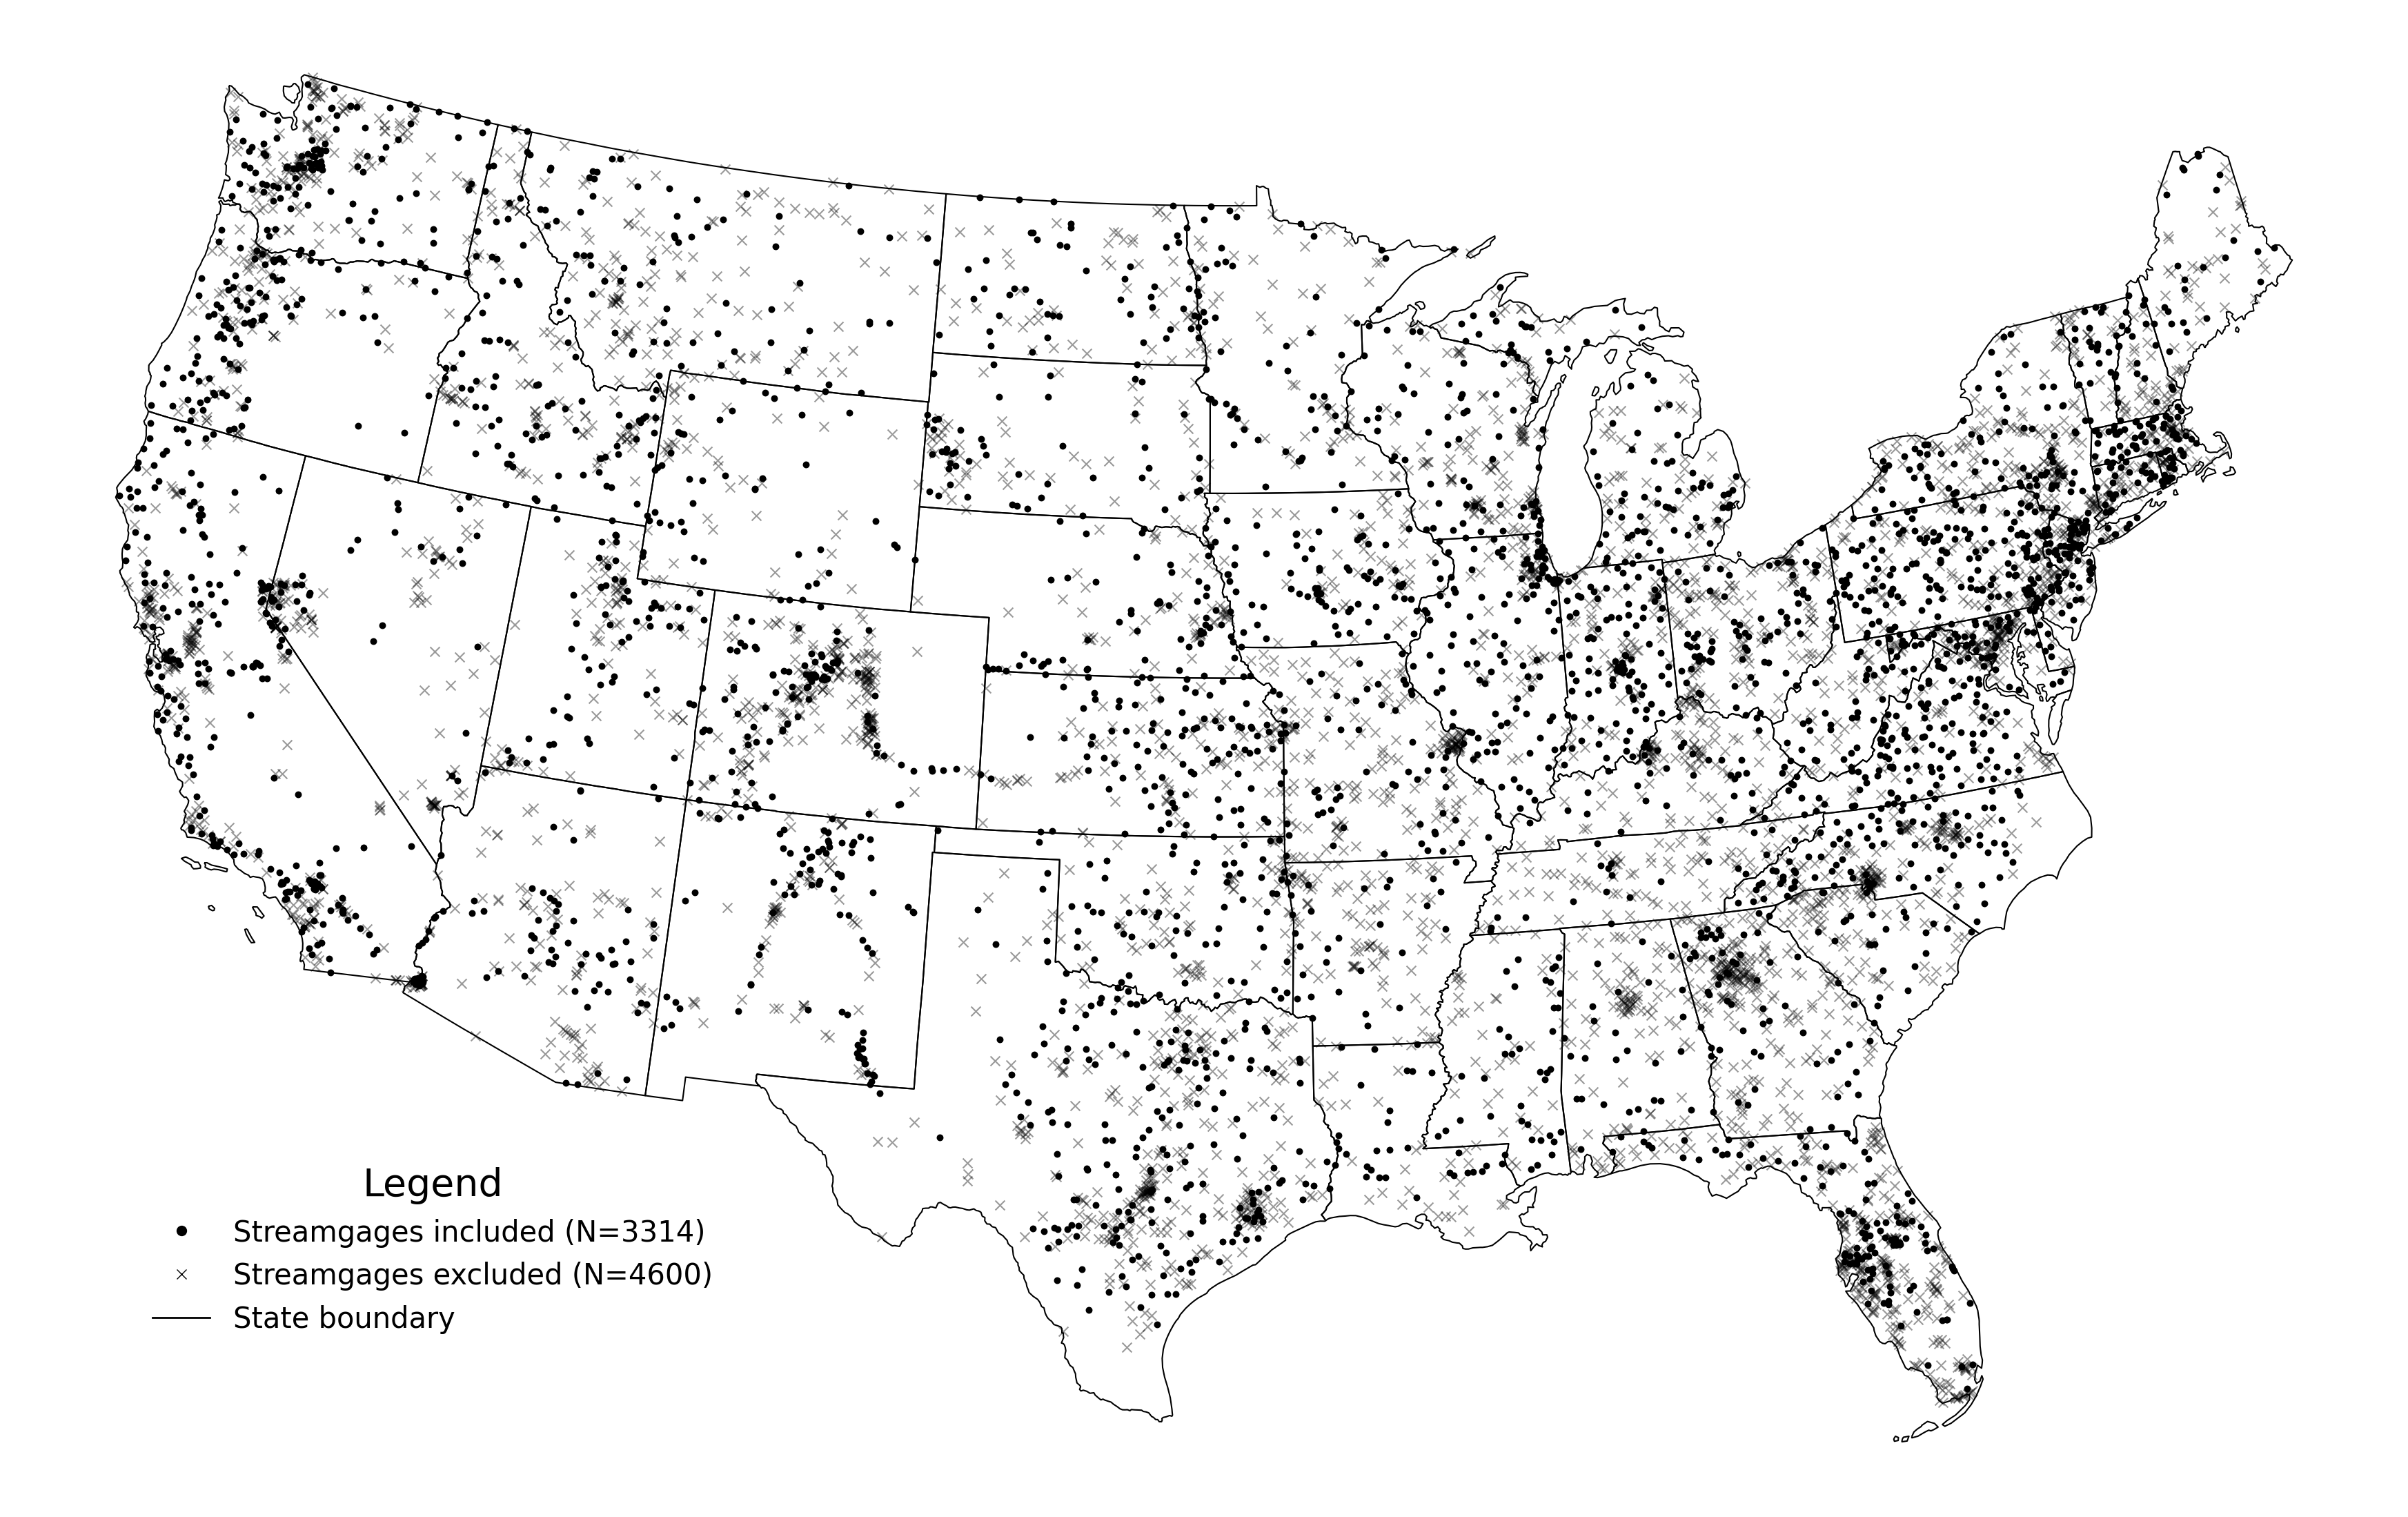

In [159]:
from matplotlib.lines import Line2D

date_range = '50'
percentile = '90'
extent = 'conus'
df = dfs_metrics[f'{date_range}_{percentile}']

fig, ax = plt.subplots(figsize=(35, 35))

# Plot lower48 states
lower48 = lower48.to_crs('ESRI:102003')
lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

# Plot selected aquifers
#aq_usgs_selected_25 = aq_usgs_selected_25.to_crs('ESRI:102003')
#aq_usgs_selected_25.plot(ax=ax, edgecolor='darkgrey', facecolor='darkgrey', linewidth=1.0)

# Prepare geo_df for plotting
geo_df = fn.convert_geometry(df)
geo_df = geo_df.merge(df, how='left', left_index=True, right_index=True)
geo_df.crs = "epsg:4269"
geo_df = geo_df.to_crs('ESRI:102003')

# Split into valid and invalid gages
geo_df_invalid = geo_df.loc[geo_df['valid'] == False]
geo_df_valid = geo_df.loc[geo_df['valid'] == True]

# Plot gauges
geo_df_valid.plot(ax=ax, color='black', label=f'Streamgages include (N={len(geo_df_valid)})', markersize=150, marker='.', alpha=1.0, legend=True)
geo_df_invalid.plot(ax=ax, color='black', label=f'Streamgages excluded (N={len(geo_df_invalid)})', markersize=100, marker='x', alpha=0.4, legend=True)

# Create custom legend entries
state_boundary_line = Line2D([0], [0], color='black', lw=2, label='State boundary')
valid_marker = Line2D([0], [0], marker='o', color='black', markersize=10, linestyle='None', label=f'Streamgages included (N={len(geo_df_valid)})')
invalid_marker = Line2D([0], [0], marker='x', color='black', markersize=10, linestyle='None', label=f'Streamgages excluded (N={len(geo_df_invalid)})')

# Add custom legend
handles = [valid_marker, invalid_marker, state_boundary_line]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.05, 0.1), fontsize=30, title="Legend", title_fontsize=40, frameon=False)

plt.axis("off")
plt.tight_layout()

plt.savefig(f'Saved_Visuals/Valid_gages/valid_gages_{extent}_{date_range}_{percentile}.png', bbox_inches='tight')

plt.show()

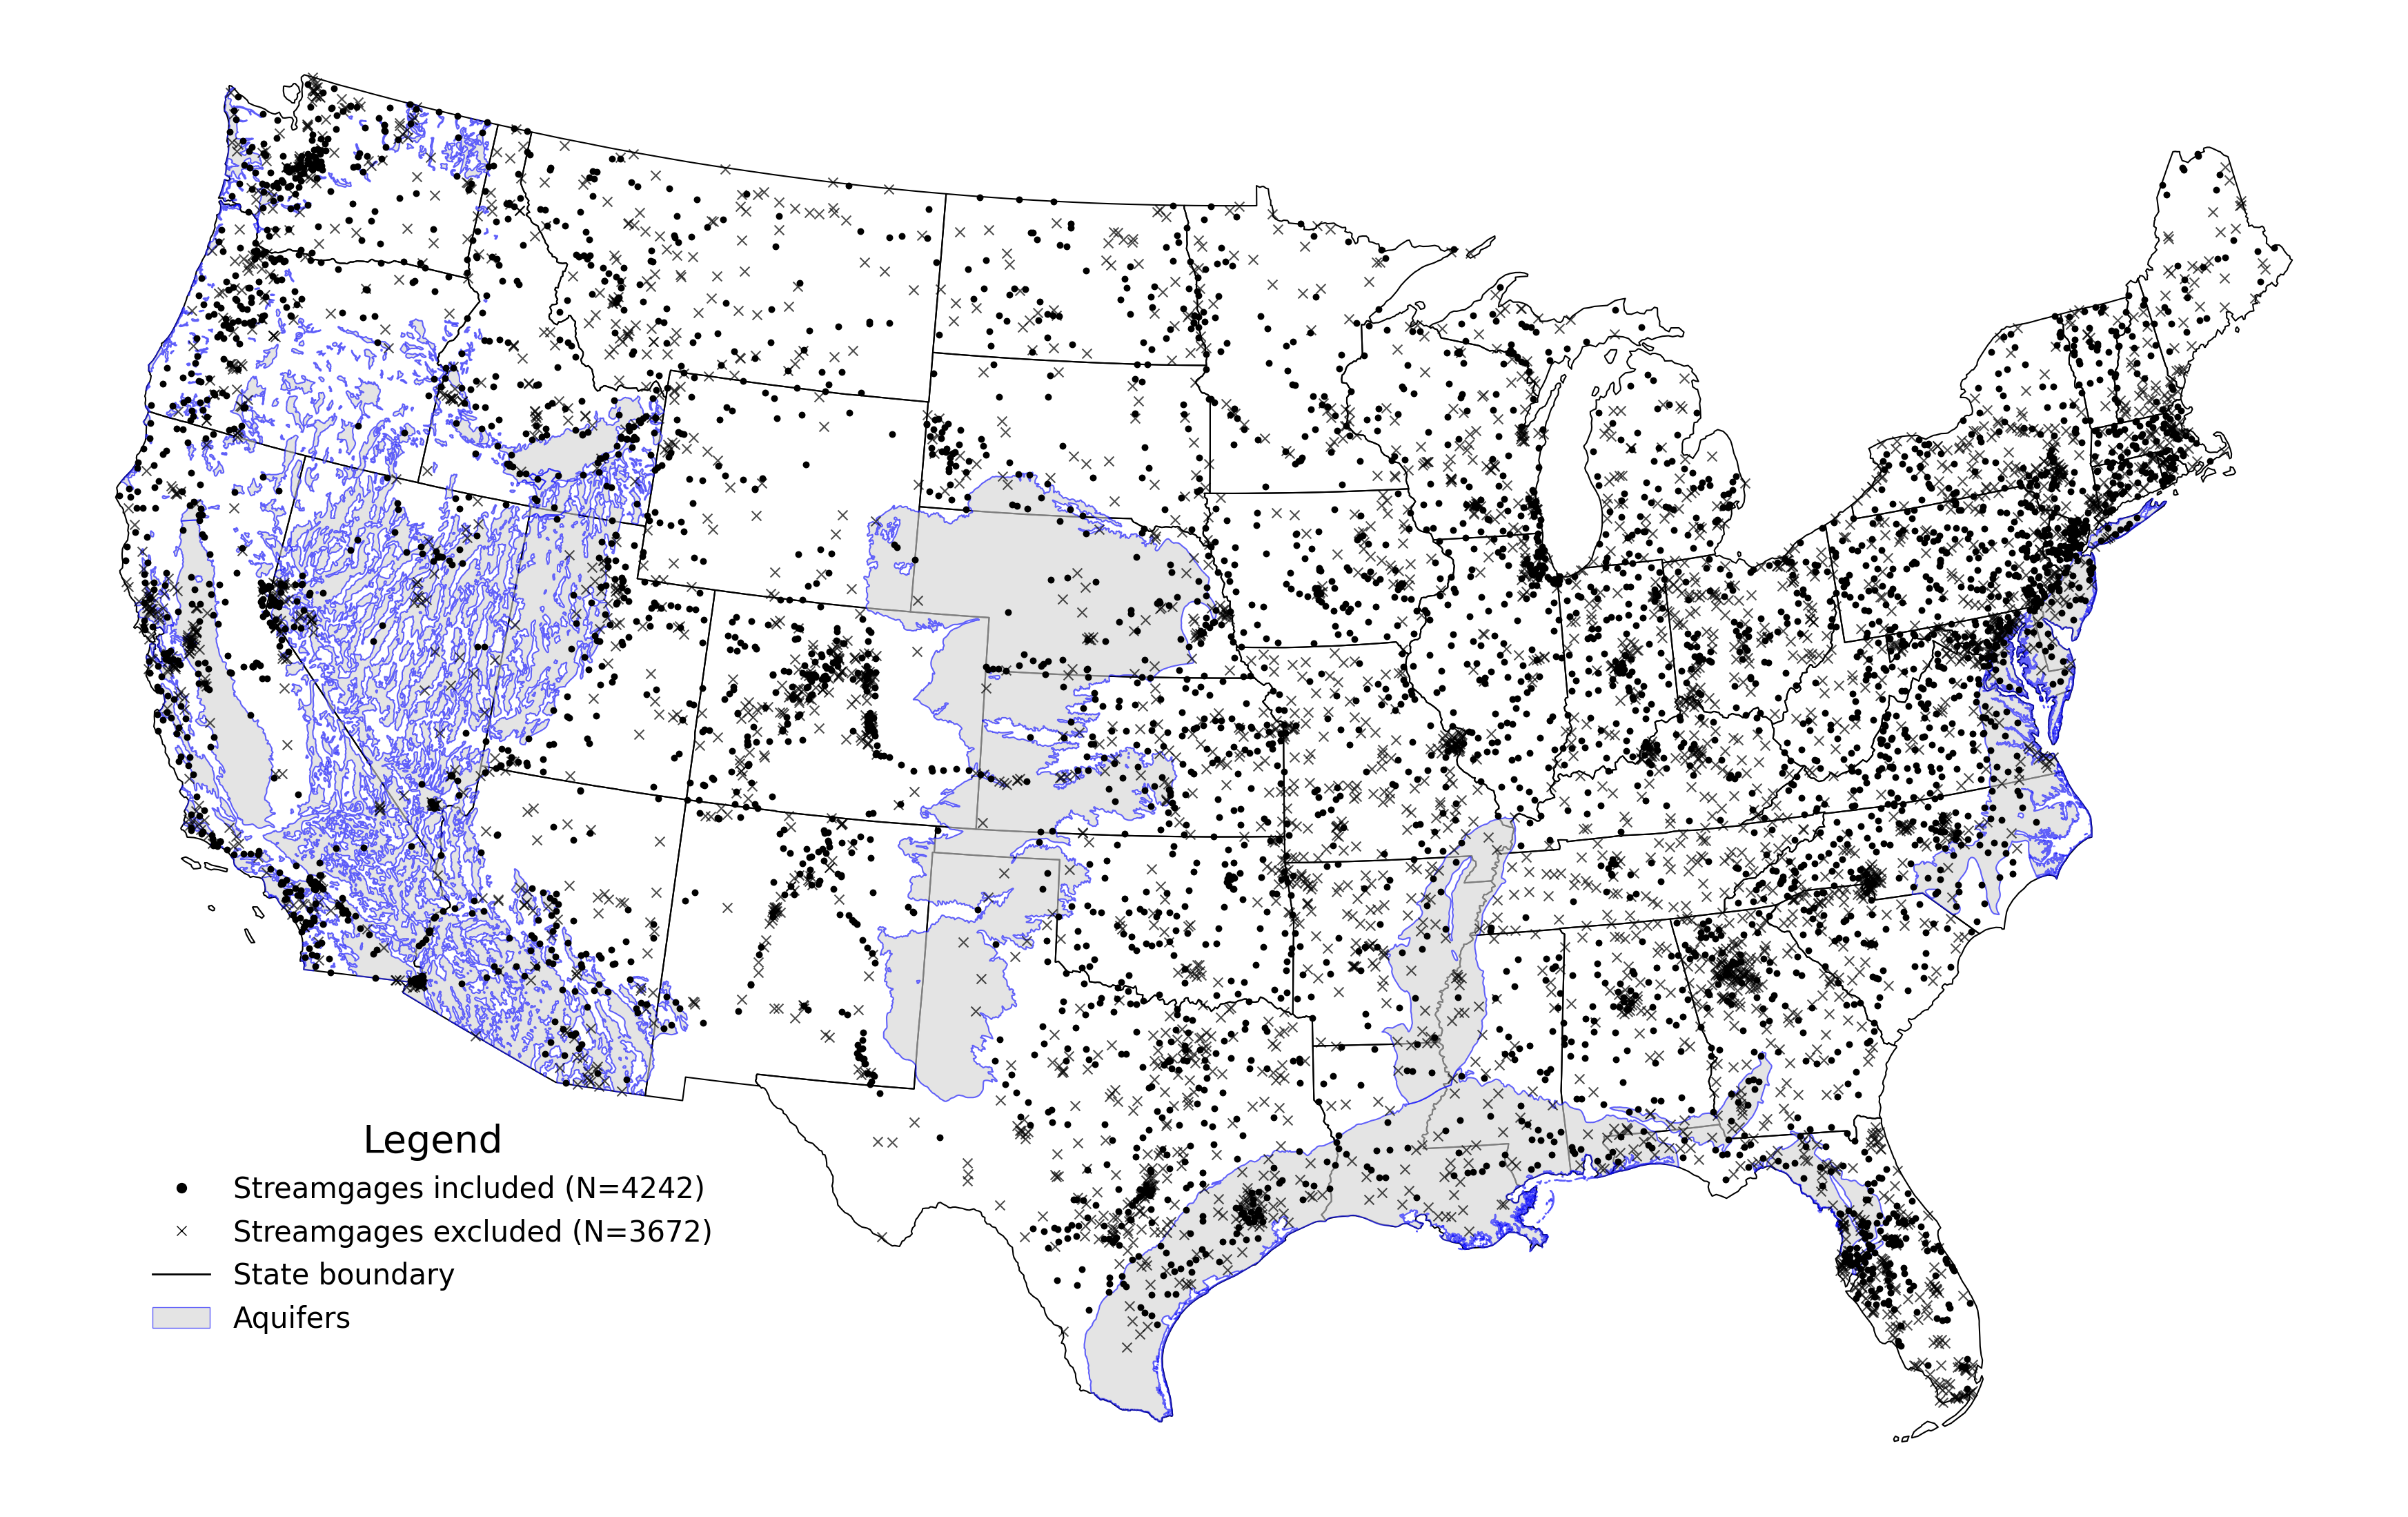

In [180]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

date_range = '30'
percentile = '90'
extent = 'aq10'
df = dfs_metrics[f'{date_range}_{percentile}']


fig, ax = plt.subplots(figsize=(35, 35))

# Plot lower48 states
lower48 = lower48.to_crs('ESRI:102003')
lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

# Plot selected aquifers
if extent == 'aq25':
    aq_usgs_selected_25 = aq_usgs_selected_25.to_crs('ESRI:102003')
    aq_usgs_selected_25.plot(ax=ax, edgecolor='blue', facecolor='lightgrey', linewidth=1.5, alpha=0.6)

if extent == 'aq10':
    aq_usgs_selected_10 = aq_usgs_selected_10.to_crs('ESRI:102003')
    aq_usgs_selected_10.plot(ax=ax, edgecolor='blue', facecolor='lightgrey', linewidth=1.5, alpha=0.6)

if extent == 'aq7':
    aq_usgs_selected_7 = aq_usgs_selected_7.to_crs('ESRI:102003')
    aq_usgs_selected_7.plot(ax=ax, edgecolor='blue', facecolor='lightgrey', linewidth=1.5, alpha=0.6)

# Prepare geo_df for plotting
geo_df = fn.convert_geometry(df)
geo_df = geo_df.merge(df, how='left', left_index=True, right_index=True)
geo_df.crs = "epsg:4269"
geo_df = geo_df.to_crs('ESRI:102003')

# Split into valid and invalid gages
geo_df_invalid = geo_df.loc[geo_df['valid'] == False]
geo_df_valid = geo_df.loc[geo_df['valid'] == True]

# Plot gauges
geo_df_valid.plot(ax=ax, color='black', label=f'Streamgages include (N={len(geo_df_valid)})', markersize=150, marker='.', alpha=1.0, legend=True)
geo_df_invalid.plot(ax=ax, color='black', label=f'Streamgages excluded (N={len(geo_df_invalid)})', markersize=100, marker='x', alpha=0.7, legend=True)

# Create custom legend entries
state_boundary_line = Line2D([0], [0], color='black', lw=2, label='State boundary')
valid_marker = Line2D([0], [0], marker='o', color='black', markersize=10, linestyle='None', label=f'Streamgages included (N={len(geo_df_valid)})')
invalid_marker = Line2D([0], [0], marker='x', color='black', markersize=10, linestyle='None', label=f'Streamgages excluded (N={len(geo_df_invalid)})')
aquifer_patch = Patch(facecolor='lightgrey', edgecolor='blue', label='Aquifers', alpha=0.6)

# Add custom legend
handles = [valid_marker, invalid_marker, state_boundary_line, aquifer_patch]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.05, 0.1), fontsize=30, title="Legend", title_fontsize=40, frameon=False)

plt.axis("off")
plt.tight_layout()

plt.savefig(f'Saved_Visuals/Valid_gages/valid_gages_{extent}_{date_range}_{percentile}.png', bbox_inches='tight')

plt.show()

## Comparison of HMF volumes

In [83]:
aq_withdrawals = pd.read_excel('us_aq_withdrawals.xlsx')

In [84]:
metric = 'annual_hmf'
df_sum_annual_hmf = {}
for date_range in date_ranges:
    for percentile in percentiles:

        # Loop through each aq code to calculate the sum of the annual_hmf
        sum_list = []
        for aq in aq_codes_25:
            sums = df_outlet_gages[f'{date_range}_{percentile}'][aq][metric].sum()
            sum_list.append(sums)
            
        df_sum_annual_hmf[f'{date_range}_{percentile}'] = pd.DataFrame(sum_list, list(aq_names_25.values()))

In [85]:
df_compare_hmf = {}
for date_range in date_ranges:
    for percentile in percentiles:
        df1 = df_sum_annual_hmf[f'{date_range}_{percentile}'].reset_index()
        df_compare_hmf[f'{date_range}_{percentile}'] = df1.join(aq_withdrawals)
        df_compare_hmf[f'{date_range}_{percentile}'].rename(columns={0:'annual_hmf_sum_km3'}, inplace=True)
        df_compare_hmf[f'{date_range}_{percentile}'].rename(columns={'index':'aq_name'}, inplace=True)
        df_compare_hmf[f'{date_range}_{percentile}'].drop(columns=['Aquifer_name'], inplace=True)

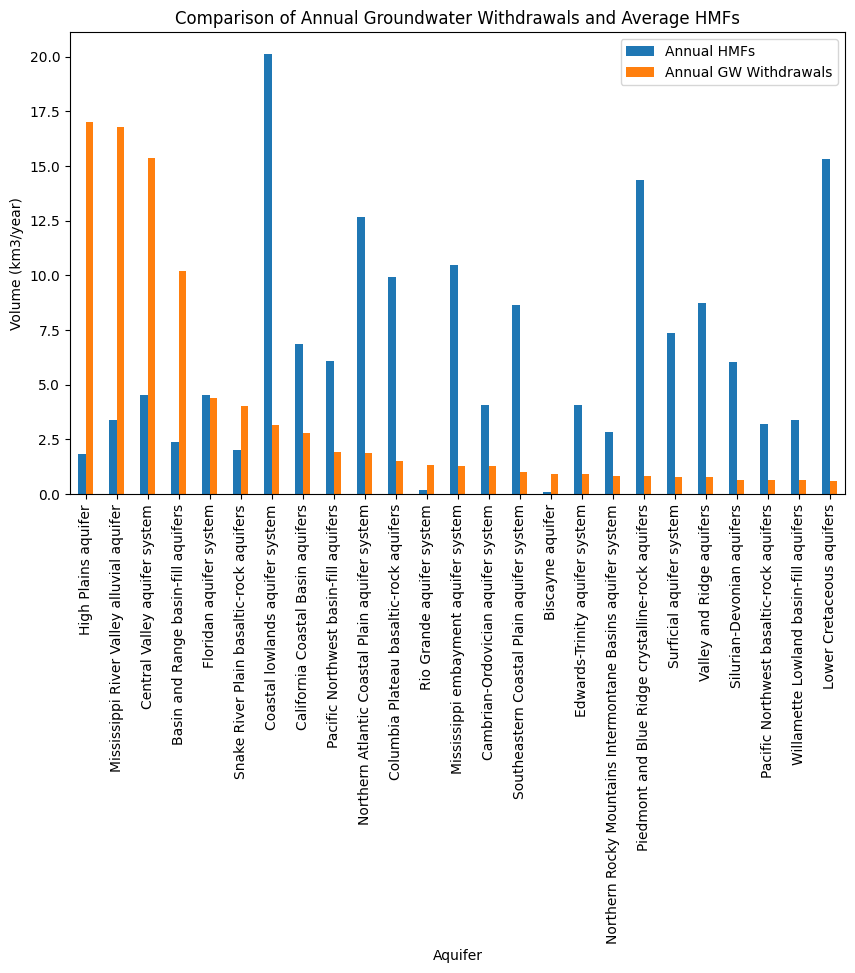

In [86]:
date_range = '30'
percentile = '90'
df = df_compare_hmf[f'{date_range}_{percentile}']
#df
df.set_index('aq_name', inplace=True)
columns_to_compare = ['annual_hmf_sum_km3', 'Total_withdrawls_km3_year']
ax = df[columns_to_compare].plot(kind='bar', figsize=(10, 6))
ax.legend(['Annual HMFs', 'Annual GW Withdrawals'])

plt.title('Comparison of Annual Groundwater Withdrawals and Average HMFs')
plt.xlabel('Aquifer')
plt.ylabel('Volume (km3/year)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.savefig(f'Saved_Visuals/Aquifers/HMF_vol_compare/HMF_vol_{date_range}_{percentile}.png', bbox_inches='tight')
plt.show()

In [10]:
#import geopandas as gpd
#import matplotlib.colors as mcolors
aq_usgs_selected_10 = gpd.read_file('ShapeFiles/Aquifers_USGS_10/Aquifers_USGS_10.shp')
aq_list_10 = aq_usgs_selected_10['AQ_NAME'].tolist()
color_names_10 = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
#color_names_10 = ['darkorange', 'lightgreen', 'tomato', 'yellow', 'orange', 
#                  'red', 'orangered', 'limegreen', 'forestgreen', 'gold']
colors_by_name_10 = [mcolors.CSS4_COLORS[name] for name in color_names_10]
colors_dict_10 = dict(zip(aq_list_10, colors_by_name_10))

In [82]:
metric = 'timing'
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
aq_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
alpha_list = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
date_range = '30'
percentile = '90'

def outlet_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(18, 6))
    # plt.boxplot([df_outlet_gages[f'{date_range}_{percentile}']['hp'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['mr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cv'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['br'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['fl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['sr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cc'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['pn'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['na'][metric]
    #             ])

    for j, aq_code in enumerate(aq_codes):
        ax.boxplot(df_outlet_gages[f'{date_range}_{percentile}'][aq_code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=aq_colors[j], alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['High Plains',
                    'Mississippi \n River Valley',
                    'Central Valley ',
                    'Basin and \n Range',
                    'Floridan',
                    'Snake River \n Plain',
                    'Coastal \n Lowlands',
                    'California \n Coastal Basin ', 
                    'Pacific \n Northwest ',
                    'Northern Atlantic \n Coastal Plain']

    plt.xticks([0,1,2,3,4,5,6,7,8,9], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/Aquifers/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return
              
# for date_range in date_ranges:
#     for percentile in percentiles:
#         for metric in metric_list:
#               outlet_gages_metrics_boxplot(metric, date_range, percentile)

In [ ]:
metric = 'timing'
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
aq_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
alpha_list = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
date_range = '30'
percentile = '90'

def outlet_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(18, 6))
    # plt.boxplot([df_outlet_gages[f'{date_range}_{percentile}']['hp'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['mr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cv'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['br'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['fl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['sr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cc'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['pn'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['na'][metric]
    #             ])

    for j, aq_code in enumerate(aq_codes):
        ax.boxplot(df_outlet_gages[f'{date_range}_{percentile}'][aq_code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=aq_colors[j], alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['High Plains',
                    'Mississippi \n River Valley',
                    'Central Valley ',
                    'Basin and \n Range',
                    'Floridan',
                    'Snake River \n Plain',
                    'Coastal \n Lowlands',
                    'California \n Coastal Basin ', 
                    'Pacific \n Northwest ',
                    'Northern Atlantic \n Coastal Plain']

    plt.xticks([0,1,2,3,4,5,6,7,8,9], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/Aquifers/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return
              
for date_range in date_ranges:
    for percentile in percentiles:
        for metric in metric_list:
              outlet_gages_metrics_boxplot(metric, date_range, percentile)

### Sort by HUC2

In [52]:
df_temp = dfs_valid['30_90']
huc2_codes = dfs_valid['30_90']['huc2_code'].unique().tolist()
#huc2_codes
dict_huc2 = {}
for huc2_code in huc2_codes:
    dict_huc2[huc2_code] = df_temp[df_temp['huc2_code'] == huc2_code]['site_no'].unique().tolist()
#dict_huc2 

In [53]:
df_huc2_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_huc2_huc = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in dict_huc2.items():
            df_huc2_huc[key] = df_temp[df_temp['site_no'].isin(value)]
       
        df_huc2_gages[f'{date_range}_{percentile}'] = df_huc2_huc

In [54]:
huc2_codes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink',
               'teal', 'lavender', 'brown', 'black', 'maroon', 'lightblue', 'coral', 'olive']
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']

def huc2_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(20, 6))
    # plt.boxplot([df_huc2_gages[f'{date_range}_{percentile}'][1][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][2][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][3][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][4][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][5][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][6][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][7][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][8][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][9][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][10][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][11][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][12][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][13][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][14][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][15][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][16][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][17][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][18][metric]
    #             ])

    for j, code in enumerate(huc2_codes):
        ax.boxplot(df_huc2_gages[f'{date_range}_{percentile}'][code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=colors[j]), #alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['HUC1', 'HUC2', 'HUC3', 'HUC4', 'HUC5', 'HUC6', 'HUC7', 'HUC8', 'HUC9',
                   'HUC10', 'HUC11', 'HUC12', 'HUC13', 'HUC14', 'HUC15', 'HUC16', 'HUC17', 'HUC18']

    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/HUC2/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return

# for date_range in date_ranges:
#     for percentile in percentiles:
#         for metric in metric_list:
#               huc2_gages_metrics_boxplot(metric, date_range, percentile)

## Event frequency duration curve

### Generate events subdf for all outlet gages

In [88]:
# Function to calculate subdf for given gage
df_results = pd.DataFrame()

# This is a cut down version of single_site_analysis() focused only on event metrics
def events_subdf(site, date_range, quantile):
    CUBIC_FT_KM_FACTOR = 0.0000000000283168466
    #if i == test_limit: break
    df = nwis.get_record(sites=site, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    df = df.reset_index()

    # Only run on valid sites so this should never be the case but check anyways
    #if df.empty: continue

    if '00060_radar sensor_Mean' in df.columns and '00060_Mean' not in df.columns:
        df.rename(columns={'00060_radar sensor_Mean': '00060_Mean'}, inplace=True)

    df = fn.merge_tidal(df)

    # Cropping to date range
    df = df.reset_index()
    date_range = int(date_range)
    date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * date_range)
    df = df[df['datetime'].dt.date >= date_threshold]

    threshold = fn.calc_threshold(df, (int(quantile) / 100))
    _, hmf_series_cont = fn.filter_hmf(df, threshold)
    hmf_series_cont_cfs = fn.convert_hmf(hmf_series_cont, threshold)

    hmf_series_cont['00060_Mean'] = hmf_series_cont_cfs['00060_Mean'] * CUBIC_FT_KM_FACTOR
    #hmf_series_cont.to_csv('hmf_series_cont.csv')

    # Insert a dummy row at the end to ensure the last event is captured
    last = hmf_series_cont['datetime'].iloc[-1] + timedelta(days=1)
    insert = {'datetime': last, '00060_Mean': 0, 'site_no': site}
    hmf_series_cont = pd.concat([hmf_series_cont, pd.DataFrame(insert, index=[0])]).reset_index(drop=True)

    event_count = hmf = duration = 0
    event = False
    start = end = None
    df_results = pd.DataFrame()
    for i, row in hmf_series_cont.iterrows():     

        # No current event and none starting now
        if row['00060_Mean'] == 0 and event == False:
            event = False
            continue

        # New event starting
        if row['00060_Mean'] > 0 and event == False:
            hmf = row['00060_Mean']
            start = row['datetime'].date()
            duration = 1
            event_count += 1
            event = True
            continue

        # Current event continuing
        if row['00060_Mean'] > 0 and event == True:
            hmf += row['00060_Mean']
            duration += 1
            event = True
            continue

        # Current event ending, add to dataframe
        if row['00060_Mean'] == 0 and event == True:
            end = row['datetime'].date() - timedelta(days=1)
            data = {'site_no': site, 'event': event_count, 'start': start, 'end': end, 'hmf': hmf, 'duration': duration}
            df_results = pd.concat([df_results, pd.DataFrame(data, index=[0])])
            event = False
            continue

    df_results = df_results.reset_index(drop=True) 
    return df_results#, hmf_series_cont
    #df_results.to_csv(f'events_subdf.csv')

In [89]:
# QA/QC for one gage
date_range = 50
quantile = 95
df_results_test = events_subdf('12040500', date_range, percentile)
df_results_test[0:20]
#subdf_test = df_test[(df_test['datetime'] > '2019-02-13') & (df_test['datetime'] < '2019-02-24')]
#subdf_test['00060_Mean'].sum()

site_no  event       start         end       hmf  duration
0   12040500      1  1974-04-01  1974-04-01  0.001664         1
1   12040500      2  1974-04-06  1974-04-06  0.004600         1
2   12040500      3  1974-04-11  1974-04-11  0.001664         1
3   12040500      4  1974-05-24  1974-05-26  0.049763         3
4   12040500      5  1974-07-17  1974-07-17  0.003132         1
5   12040500      6  1974-11-12  1974-11-12  0.008759         1
6   12040500      7  1974-11-20  1974-11-21  0.058620         2
7   12040500      8  1974-11-24  1974-11-25  0.063758         2
8   12040500      9  1974-12-10  1974-12-11  0.013603         2
9   12040500     10  1974-12-16  1974-12-22  0.088468         7
10  12040500     11  1974-12-29  1974-12-30  0.004306         2
11  12040500     12  1975-01-08  1975-01-08  0.000685         1
12  12040500     13  1975-01-12  1975-01-13  0.038313         2
13  12040500     14  1975-01-17  1975-01-19  0.046534         3
14  12040500     15  1975-02-12  1975-02-13  0.045653         2
15  12040500     16  1975-03-02  1975-03-03  0.027548         2
16  12040500     17  1975-05-03  1975-05-04  0.010422         2
17  12040500     18  1975-08-29  1975-08-29  0.017322         1
18  12040500     19  1975-10-16  1975-10-20  0.167590         5
19  12040500     20  1975-10-27  1975-10-27  0.001174         1

### Events subdf generation for outlet gages (DO NOT NEED TO RUN AGAIN)

In [104]:
# Generate events subdf nested dictionary with each key for the aquifer, and nested keys for the gage number
aq_events_dict = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        aq_events = {}
        for aq in aq_codes_10:
            print(aq)
            gages = outlet_gages_dict_10[aq]
            events_by_gage = {}
            for gage in gages:
                print(gage)
                events_by_gage[gage] = events_subdf(gage, date_range, percentile)
            aq_events[aq] = events_by_gage
        aq_events_dict[f'{date_range}_{percentile}'] = aq_events
        print(f'{date_range}_{percentile}_done')
        
# aq_events_dict = {}
# for date_range in ['30']:
#     for percentile in ['90']: 
# # for date_range in date_ranges:
# #     for percentile in percentiles: 
#         aq_events = {}
#         #for aq in ['pn']:
#         for aq in aq_codes_25:
#             print(aq)
#             gages = outlet_gages_dict_25[aq]
#             events_by_gage = {}
#             for gage in gages:
#                 print(gage)
#                 events_by_gage[gage] = events_subdf(gage, date_range, percentile)
#             aq_events[aq] = events_by_gage
#         aq_events_dict[f'{date_range}_{percentile}'] = aq_events
#         print(f'{date_range}_{percentile}_done')


# date_range = '50'
# percentile = '95'
# aq_events_dict = {}
# for aq in aq_codes_10:
#     gages = outlet_gages_dict_10[aq]
#     events_by_gage = {}
#     for gage in gages:
#         #print(gage)
#         events_by_gage[gage] = events_subdf(gage, date_range, percentile)
#     aq_events[aq] = events_by_gage
# aq_events_dict[f'{date_range}_{percentile}'] = aq_events

hp
06465500
06805500
06853500
06884000
07144550
07158000
07237500
07228000
07297910
08123850
mr
07077000
07077555
07047942
07369000
07369000
07285500
07268000
cv
11303500
11447650
br
09520500
09429600
09521100
09519800
09468500
09423000
10327500
10351650
10351650
10311400
fl
02368000
02365500
02358000
02320500
02313230
sr
13269000
cl
08211000
08188500
08176500
08164000
08162000
08116650
08066500
08033500
08068000
08030500
08013500
08012000
07378500
02492000
02489500
02479000
02479300
02469761
02428400
02375500
cc
11023000
11046000
11078000
11087020
11133000
11140000
11152500
11159000
11467000
11477000
11530500
11532500
pn
11039800
12200500
12040500
14211720
14372300
na
02105769
02089500
02091500
02083500
02085000
02052000
02047000
02049500
02041650
02037500
01668000
01673000
01646500
01578310
01474500
01463500
30_90_done
hp
06465500
06805500
06853500
06884000
07144550
07158000
07237500
07228000
07297910
08123850
mr
07077000
07077555
07047942
07369000
07369000
07285500
07268000
cv
11303

KeyError: '00060_Mean'

In [93]:
import pickle 

with open('Prelim_Data/events_subdf_10.pkl', 'wb') as f:
   pickle.dump(aq_events_dict, f)
    
# with open('Prelim_Data/events_subdf_25.pkl', 'wb') as f:
#     pickle.dump(aq_events_dict, f)

### Function: Sort and plot FDC for individual gages in given aquifer

In [94]:
# Group events with the same duration and calculate the sum/mean of HMFs of that duration, and count number of events
# df is the list of events for one gage

def sort_events(df, by='sum'):
    df_sort_dur = df.sort_values('duration')
    
    # Group events with the same duration and sum or take the mean of the hmfs of that duration
    df_sort = df_sort_dur.groupby('duration')['hmf'].agg([by, 'size']).reset_index()
    
    # Name columns
    df_sort = df_sort.rename(columns={'size':'count'})
    df_sort = df_sort.rename(columns={by:'hmf'})  
    
    return df_sort

# QA/QC: Sort events by duration and then sum hmfs of the same duration
# df = events_by_date_perc['cv']['11447650']
# df_sort_dur = df.sort_values('duration')
# print(df_sort_dur)
# df_grouped = df.groupby('duration')['hmf'].agg(['sum', 'size']).reset_index()
# print(df_grouped)

In [95]:
# Function to generate the FDC for a single gage
import matplotlib.ticker as mticker

def fdc_single_site(df, aq):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    cm = plt.cm.get_cmap('OrRd') #RdYlBl
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=18)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=18)
    ax.set_ylabel('Number of HMF events', fontsize=18)
    ax.set_title(f'HMF Event Frequency Duration Curve: \n Gage No:{int(gage)}', fontsize=20)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    if aq == 'cv':
        ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax.yaxis.get_minor_formatter().set_scientific(False)
        ax.yaxis.get_minor_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/gages/fdc_{aq}_{gage}.png'
    plt.savefig(img_path, bbox_inches='tight')

    plt.show()
    return

### Function: Group events by aquifer and plot FDCs for all outlet gages

In [96]:
def group_events(gage_events):
    # Loop through gages, sort events for gages by duration, and then combine into one df
    df_list = []
    for gage in list(gage_events.keys()):
        gage_events_sort = sort_events(gage_events[gage], by='sum')
        df_list.append(gage_events_sort)
    aq_events_sort = pd.concat(df_list, ignore_index=True)

    # Group sorted gages by duration
    aq_events_grouped = aq_events_sort.groupby('duration').sum().reset_index()
    
    return aq_events_grouped

In [97]:
import matplotlib.ticker as mticker

def fdc_events(df, aq):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    cm = plt.cm.get_cmap('OrRd')
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=20)
    ax.set_ylabel('Number of HMF events', fontsize=20)
    if aq == 'Texas Gulf':
        ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq}', fontsize=24)
    else:
        ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq_names_10[aq]}', fontsize=24)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/fdc_{aq}.png'
    fn.save_plot_as_image(img_path, overwrite=True) 

    plt.show()

### Function: FDC stats for given duration ranges

In [98]:
def hmf_event_stats(df, n1, n2):
    
    events_total = df['count'].sum()
    hmf_total = df['hmf'].sum()
    dur_max = df['duration'].max()
    
    events_range = df.loc[df['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['count'].sum()
    events_perc = df.loc[df['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['count'].sum() / df['count'].sum() * 100
    hmf_range = df.loc[df['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['hmf'].sum()
    hmf_perc = df.loc[df['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['hmf'].sum() / df['hmf'].sum() * 100
    
    print('Total number of HMF events over record:', df['count'].sum())
    print('Total HMF over record:', df['hmf'].sum())
    print('Longest HMF event duration:', df['duration'].max())

    print(f'Total number of {n1}-{n2} day HMF events over record:', events_range)
    print(f'Percent of {n1}-{n2} day HMF events over record:', events_perc)
    print(f'Total HMF of {n1}-{n2} day HMF events over record:', hmf_range)
    print(f'Percent HMF of {n1}-{n2} day HMF events over record:', hmf_perc)

    return

## Run functions

### Load events_subdf for all dates and percentile combos

In [103]:
import pickle 

# Load dictionary with HMF events (date_range_percentile: aq: events)
with open('Prelim_Data/events_subdf_10.pkl', 'rb') as f:
    aq_events_dict = pickle.load(f)

EOFError: Ran out of input

In [216]:
# Texas coastal aquifers - Generate events_dict for all gages
aq = 'Texas Gulf'

date_range = '50'
quantile = '95'
gage_events_tx = {}
texas_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08068000', '08066500', '08033500', '08030500'] #'08116650',
for gage in texas_gages:
    gage_events_tx[gage] = events_subdf(gage, date_range, quantile)

### Plot FDCs for individual gages in given aquifer

In [109]:
## Texas Gulf
# for gage in texas_gages:
#     df = sort_events(gage_events_tx[gage], by='sum')
#     fdc_single_site(df, aq)

## Any aquifer
# date_range = '50'
# percentile = '95'
# aq = 'cv'
# aq_events = aq_events_dict[f'{date_range}_{percentile}']
# gage_events = aq_events[aq]
# for gage in list(gage_events.keys()):
#     df = sort_events(gage_events[gage], by='sum')
#     fdc_single_site(df, aq)

### Sort and group events in each aquifer

In [295]:
## Texas Gulf
aq_events_grouped_date_perc_tx = group_events(gage_events_tx)
#print(aq_events_grouped_date_perc_tx)

## All aquifers
# Iterate through each date range
for date_range in date_ranges:
    # For each date range, iterate through the percentiles
    for percentile in percentiles: 
        
        # Retrieve events for the current date range and percentile
        aq_events = aq_events_dict[f'{date_range}_{percentile}']

        # Dictionary to store grouped events for each aquifer
        aq_events_grouped_date_perc = {}
        
        # Loop through each aquifer for retrieved events
        for aq in list(aq_events.keys()):
            gage_events = aq_events[aq]

            # Group and sort events for each gage within the aquifer
            aq_events_grouped = group_events(gage_events)

            # Store the grouped events for the aquifer
            aq_events_grouped_date_perc[aq] = aq_events_grouped
            
        # Save the grouped events for the current date range and percentile
        aq_events_grouped_dict[f'{date_range}_{percentile}'] = aq_events_grouped_date_perc
        
## Any aquifer: SPECIFIED DATE RANGE AND PERCENTILE
# date_range = '50'
# percentile = '95'
# aq_events = aq_events_dict[f'{date_range}_{percentile}']
# aq_events_grouped_date_perc = {}
# for aq in list(aq_events.keys()):
#     gage_events = aq_events[aq]
#     aq_events_grouped = group_events(gage_events)
#     aq_events_grouped_date_perc[aq] = aq_events_grouped

### Table of an aquifer's grouped events

In [296]:
date_range = '30'
percentile = '90'
aq = 'cl'
aq_events = aq_events_grouped_dict[f'{date_range}_{percentile}']
df = aq_events[aq]
#df = aq_events_grouped_date_perc_tx
pd.set_option('display.max_rows', None)
df

duration        hmf  count
0          1   0.849108    415
1          2   4.115309    480
2          3   8.479848    421
3          4  12.871895    362
4          5  15.359108    268
5          6  23.724445    223
6          7  25.853562    166
7          8  23.518658    132
8          9  26.950877     89
9         10  29.984902    106
10        11  16.508848     78
11        12  28.026928     63
12        13  19.623003     57
13        14  24.835334     52
14        15  21.031618     43
15        16  11.135491     24
16        17  20.092805     32
17        18  11.651292     14
18        19  12.924432     18
19        20  18.406787     18
20        21   8.893410     12
21        22  13.228020     10
22        23  16.377364     23
23        24   5.441412      8
24        25   6.954403     12
25        26   8.816259      9
26        27   2.960552      3
27        28   4.108216      5
28        29   2.361782      5
29        30   4.508329      4
30        31   1.521009      2
31        32   1.481705      2
32        33   3.307770      2
33        34   2.907285      3
34        35   5.942891      4
35        36   3.349709      3
36        37  18.083949      5
37        38   6.767717      3
38        39   3.334648      4
39        40   6.980080      1
40        42   1.560066      2
41        43   3.672457      3
42        44   3.525026      2
43        45   2.062953      1
44        46   2.660406      1
45        47   0.905673      1
46        48   0.365467      1
47        49   2.695784      3
48        50   4.920357      2
49        54   0.642246      1
50        55   2.019648      1
51        56   4.559766      3
52        58   3.061400      1
53        60   1.282062      2
54        61   3.389975      1
55        62   3.659588      1
56        66   0.612133      1
57        69   1.068028      2
58        73   2.159837      1
59        84   5.081537      1
60        87   1.267497      1
61        91   5.467600      1
62        99   0.912042      1
63       110   9.757188      1
64       112   2.422428      1

In [297]:
date_range = '30'
percentile = '90'
df = aq_events_grouped_dict[f'{date_range}_{percentile}']

count_list = []
for aq in df.keys():
    count_list.append(df[aq]['count'].sum())
total_count = sum(count_list)
perc_list = count_list/total_count*100

event_count_df = pd.DataFrame({
    'Count': count_list,
    'Percentage': perc_list
}, index=df.keys())

print('Total count:', total_count)
event_count_df

Total count: 14539


Count  Percentage
hp   1910   13.137080
mr   1152    7.923516
cv     81    0.557122
br   1061    7.297613
fl    577    3.968636
sr     48    0.330147
cl   3217   22.126694
cc   2002   13.769860
pn    896    6.162735
na   3595   24.726597

### Aquifer FDC stats

In [221]:
aq_events_grouped = aq_events_grouped_dict[f'{date_range}_{percentile}']

def hmf_event_stats(df, n1, n2, n3, n4, max_dur=True):
        
    # Loop through each aquifer for retrieved events
    aq_event_stats = pd.DataFrame(columns=['events_total', 'hmf_total', 'dur_max',
                                           'n1', 'n2',
                                          'events_range1', 'events_perc1', 'hmf_range1', 'hmf_perc1',
                                           'n3', 'n4',
                                          'events_range2', 'events_perc2', 'hmf_range2', 'hmf_perc2'])
    for aq in df.keys():
        df_aq = df[aq]  
        events_total = df_aq['count'].sum()
        hmf_total = df_aq['hmf'].sum()
        dur_max = df_aq['duration'].max()
        events_range1 = df_aq.loc[df_aq['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['count'].sum()
        events_perc1 = round(df_aq.loc[df_aq['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['count'].sum() / df_aq['count'].sum() * 100)
        hmf_range1 = df_aq.loc[df_aq['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['hmf'].sum()
        hmf_perc1 = round(df_aq.loc[df_aq['duration'].isin(np.arange(n1, n2+1, 1).tolist())]['hmf'].sum() / df_aq['hmf'].sum() * 100)
        if max_dur == True:
            n4 = df_aq['duration'].max()
        events_range2 = df_aq.loc[df_aq['duration'].isin(np.arange(n3, n4+1, 1).tolist())]['count'].sum()
        events_perc2 = round(df_aq.loc[df_aq['duration'].isin(np.arange(n3, n4+1, 1).tolist())]['count'].sum() / df_aq['count'].sum() * 100)
        hmf_range2 = df_aq.loc[df_aq['duration'].isin(np.arange(n3, n4+1, 1).tolist())]['hmf'].sum()
        hmf_perc2 = round(df_aq.loc[df_aq['duration'].isin(np.arange(n3, n4+1, 1).tolist())]['hmf'].sum() / df_aq['hmf'].sum() * 100)
    
        aq_event_stats.loc[aq_names_10[aq]] = [events_total, hmf_total, dur_max,
                                               n1, n2,
                                              events_range1, events_perc1, hmf_range1, hmf_perc1,
                                               n3, n4,
                                              events_range2, events_perc2, hmf_range2, hmf_perc2]
    
    return aq_event_stats


In [291]:
n1 = 21
n2 = 49
n3 = 28 # 20
n4 = 21 #df['duration'].max()
max_dur=True

aq_event_stats_dict = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df = aq_events_grouped_dict[f'{date_range}_{percentile}']
        aq_event_stats = hmf_event_stats(df, n1, n2, n3, n4, max_dur=max_dur)
        aq_event_stats_dict[f'{date_range}_{percentile}'] = aq_event_stats

In [186]:
# Save df to excel
for date_range in date_ranges:
    for percentile in percentiles:
        file_name = f'aq_hmf_events_stats_{date_range}_{percentile}.xlsx'
        aq_event_stats_dict[f'{date_range}_{percentile}'].to_excel('Tables/'+file_name)

In [292]:
date_range = '30'
percentile = '90'
aq_event_stats_dict[f'{date_range}_{percentile}']

events_total   hmf_total  \
High Plains aquifer                                   1910.0   52.472816   
Mississippi River Valley alluvial aquifer             1152.0   85.815110   
Central Valley aquifer system                           81.0   75.227060   
Basin and Range basin-fill aquifers                   1061.0   37.646732   
Floridan aquifer system                                577.0  111.158508   
Snake River Plain basaltic-rock aquifers                48.0   36.029544   
Coastal lowlands aquifer system                       3217.0  553.001925   
California Coastal Basin aquifers                     2002.0  194.738013   
Pacific Northwest basin-fill aquifers                  896.0  175.515897   
Northern Atlantic Coastal Plain aquifer system        3595.0  377.910042   

                                                dur_max    n1    n2  \
High Plains aquifer                               114.0  21.0  49.0   
Mississippi River Valley alluvial aquifer         111.0  21.0  49.0   
Central Valley aquifer system                     177.0  21.0  49.0   
Basin and Range basin-fill aquifers               528.0  21.0  49.0   
Floridan aquifer system                           133.0  21.0  49.0   
Snake River Plain basaltic-rock aquifers          189.0  21.0  49.0   
Coastal lowlands aquifer system                   112.0  21.0  49.0   
California Coastal Basin aquifers                 162.0  21.0  49.0   
Pacific Northwest basin-fill aquifers              61.0  21.0  49.0   
Northern Atlantic Coastal Plain aquifer system     90.0  21.0  49.0   

                                                events_range1  events_perc1  \
High Plains aquifer                                      79.0           4.0   
Mississippi River Valley alluvial aquifer                59.0           5.0   
Central Valley aquifer system                            18.0          22.0   
Basin and Range basin-fill aquifers                      53.0           5.0   
Floridan aquifer system                                  37.0           6.0   
Snake River Plain basaltic-rock aquifers                  8.0          17.0   
Coastal lowlands aquifer system                         134.0           4.0   
California Coastal Basin aquifers                        93.0           5.0   
Pacific Northwest basin-fill aquifers                    23.0           3.0   
Northern Atlantic Coastal Plain aquifer system           77.0           2.0   

                                                hmf_range1  hmf_perc1    n3  \
High Plains aquifer                              21.870148       42.0  28.0   
Mississippi River Valley alluvial aquifer        32.456445       38.0  28.0   
Central Valley aquifer system                    21.006053       28.0  28.0   
Basin and Range basin-fill aquifers               4.449721       12.0  28.0   
Floridan aquifer system                          37.351619       34.0  28.0   
Snake River Plain basaltic-rock aquifers          6.275662       17.0  28.0   
Coastal lowlands aquifer system                 144.774344       26.0  28.0   
California Coastal Basin aquifers                49.490080       25.0  28.0   
Pacific Northwest basin-fill aquifers            45.466345       26.0  28.0   
Northern Atlantic Coastal Plain aquifer system   77.185864       20.0  28.0   

                                                   n4  events_range2  \
High Plains aquifer                             114.0           56.0   
Mississippi River Valley alluvial aquifer       111.0           39.0   
Central Valley aquifer system                   177.0           23.0   
Basin and Range basin-fill aquifers             528.0           74.0   
Floridan aquifer system                         133.0           42.0   
Snake River Plain basaltic-rock aquifers        189.0           10.0   
Coastal lowlands aquifer system                 112.0           79.0   
California Coastal Basin aquifers               162.0           89.0   
Pacific Northwest basin-fill aquifers    

### Plot of grouped aquifer events

C:\Users\kondris\AppData\Local\Temp\ipykernel_156228\2137726336.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('OrRd')


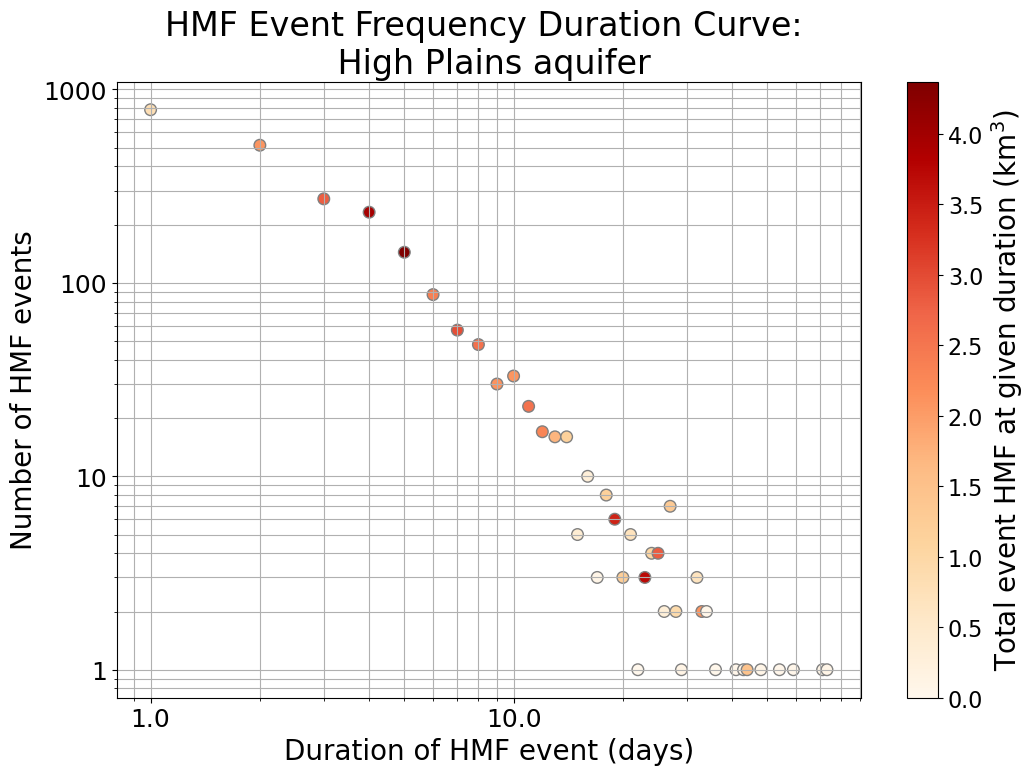

In [125]:
fdc_events(df, aq)
#fdc_events(df, 'Texas Gulf')

### All aquifers

C:\Users\kondris\AppData\Local\Temp\ipykernel_156228\2137726336.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('OrRd')


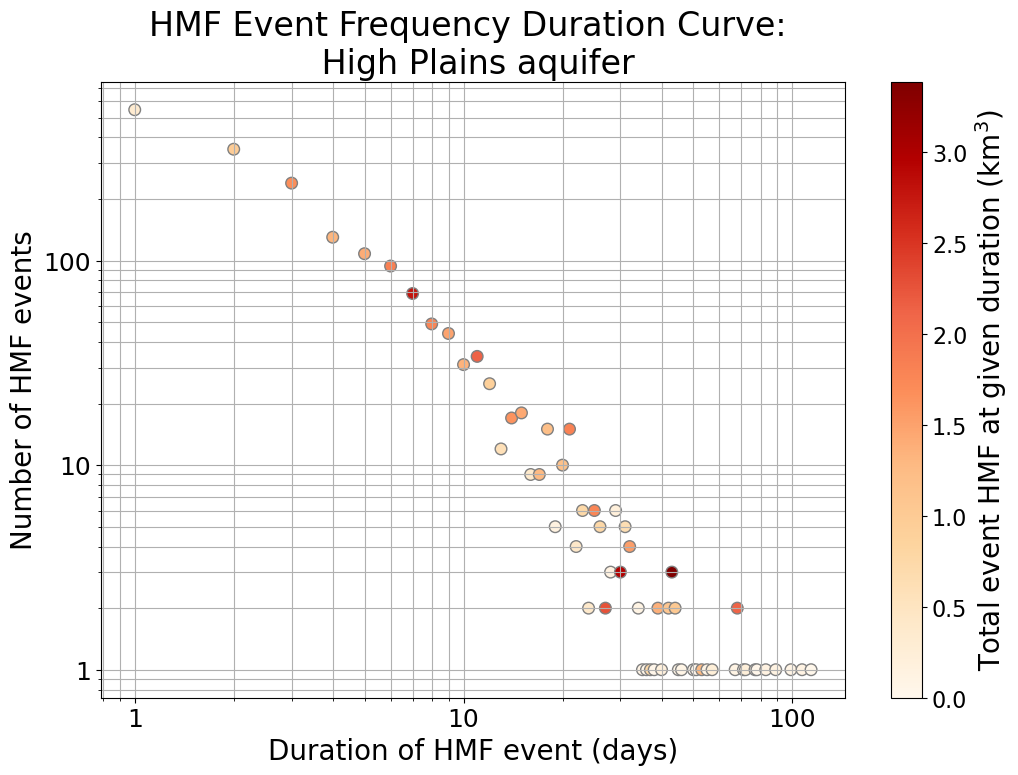

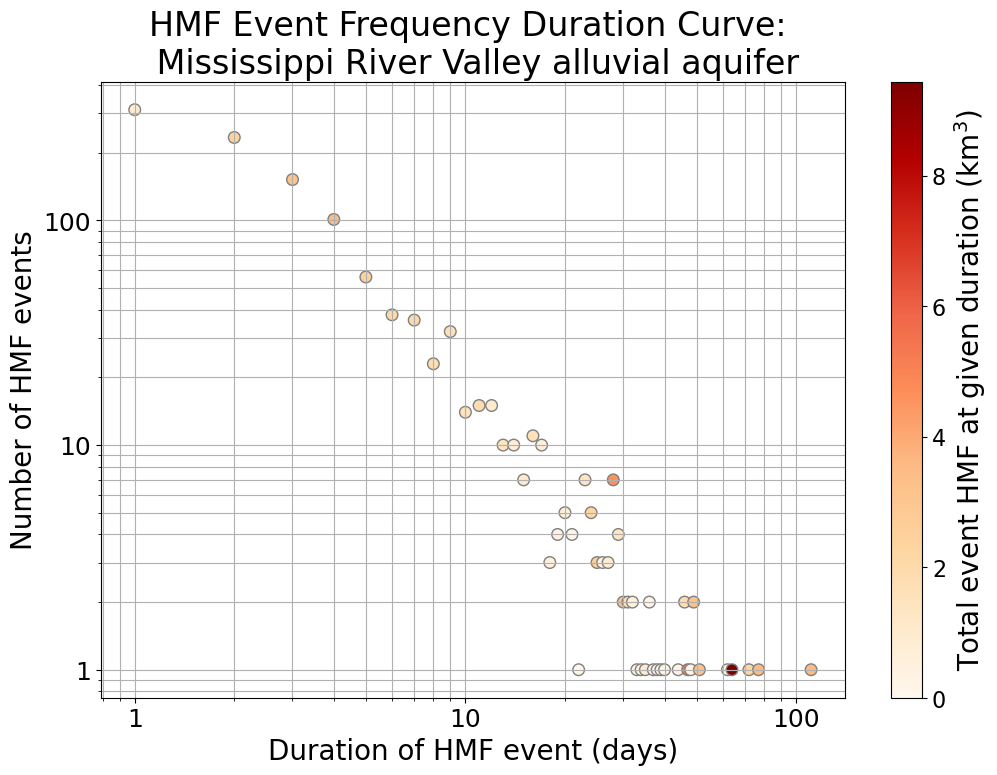

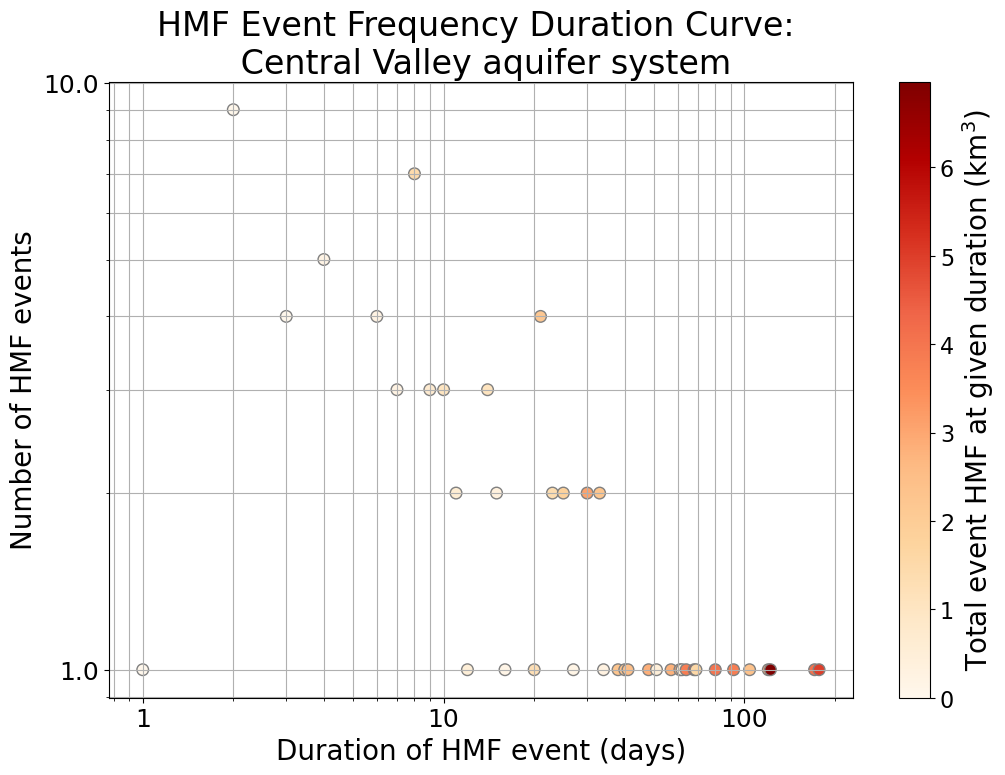

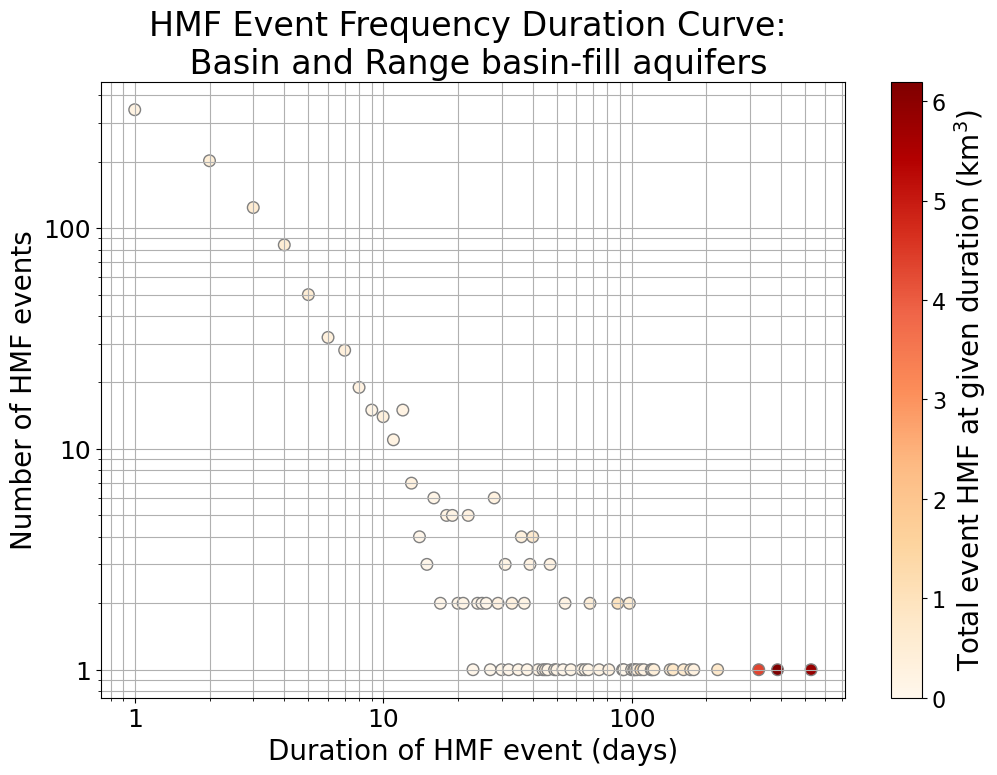

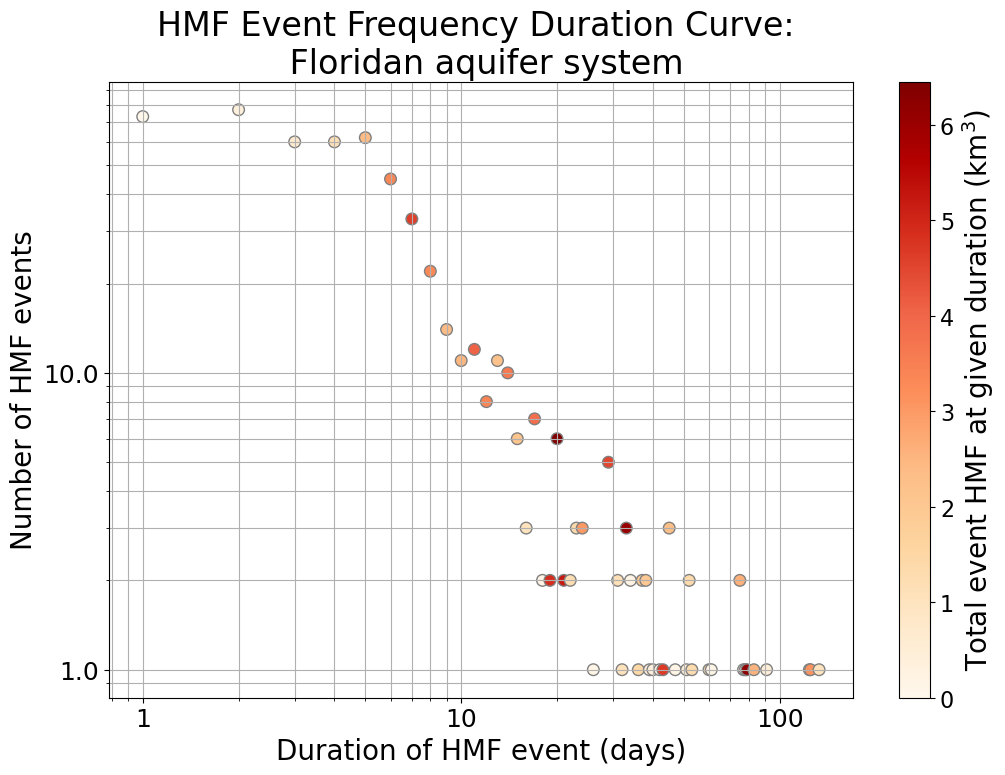

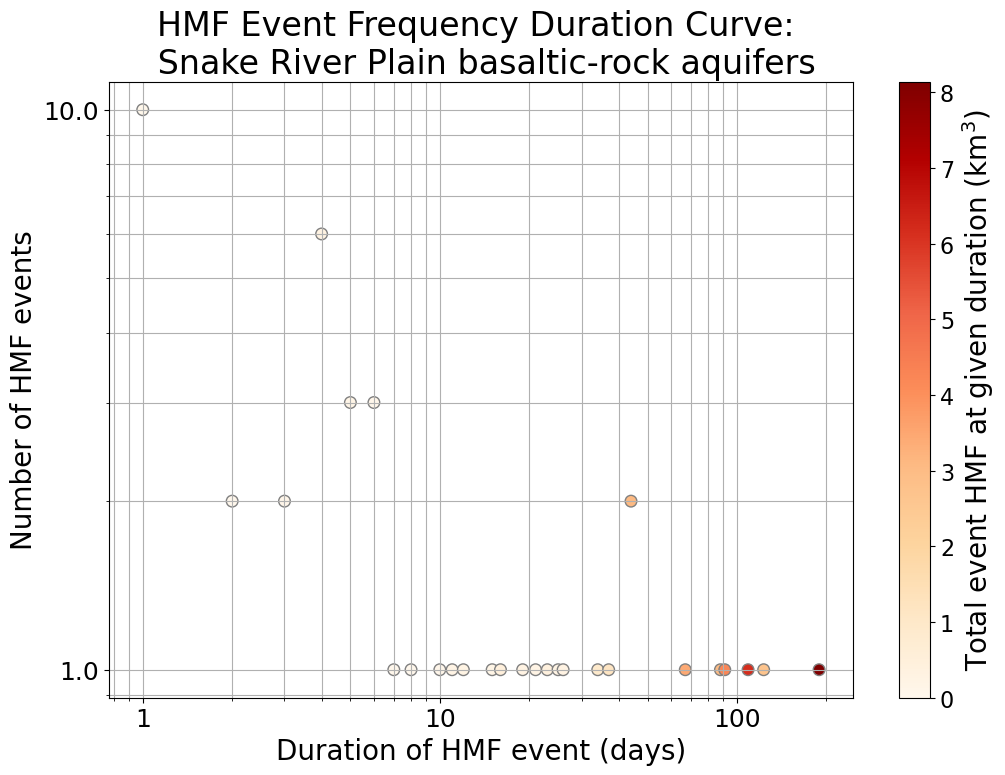

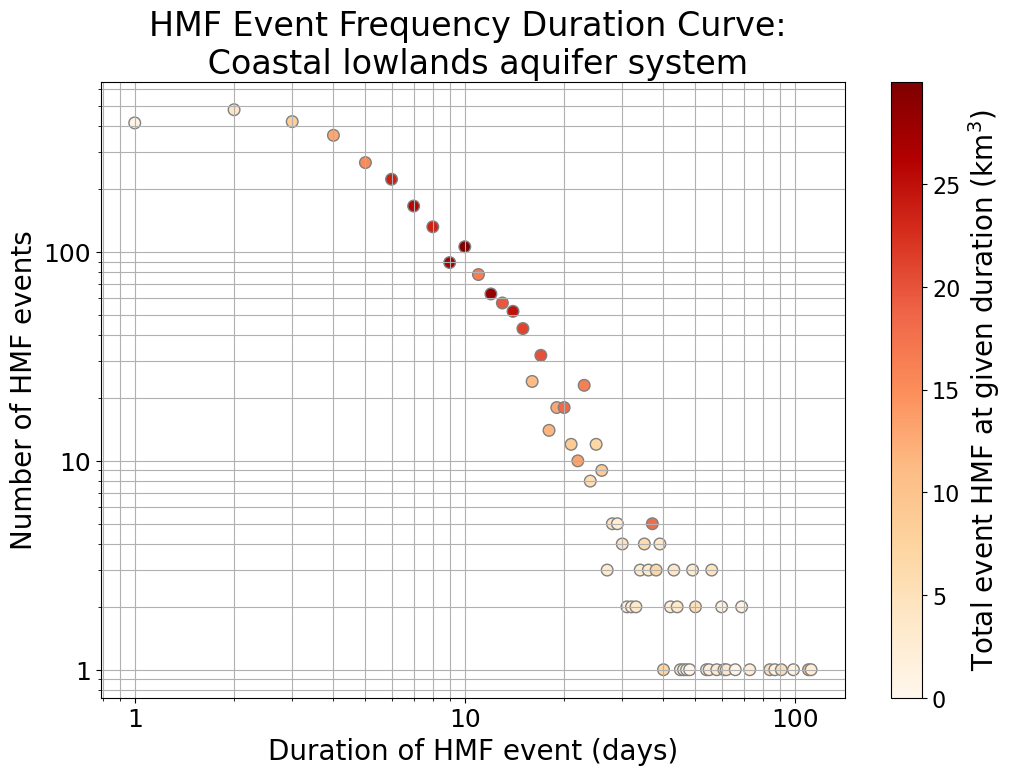

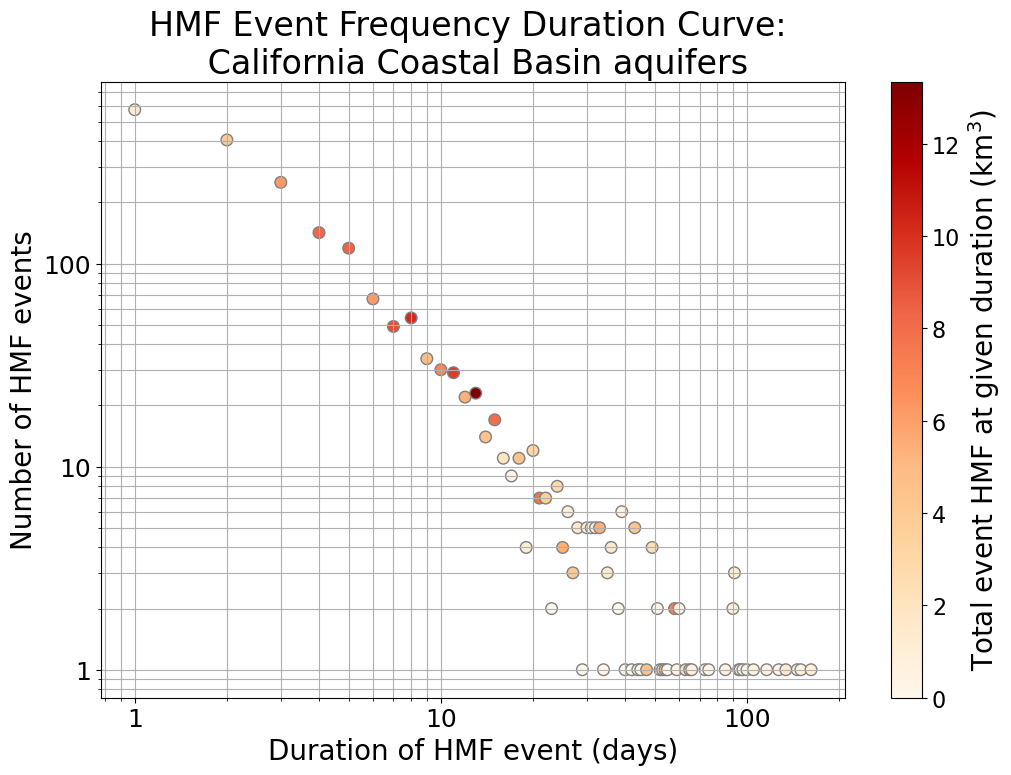

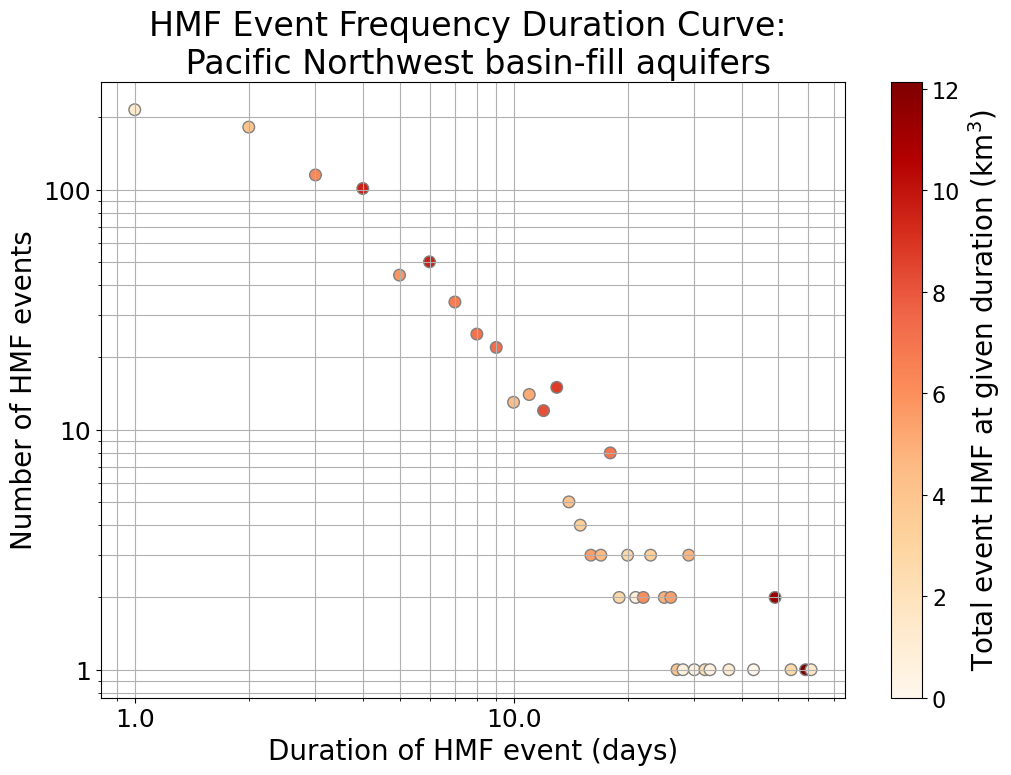

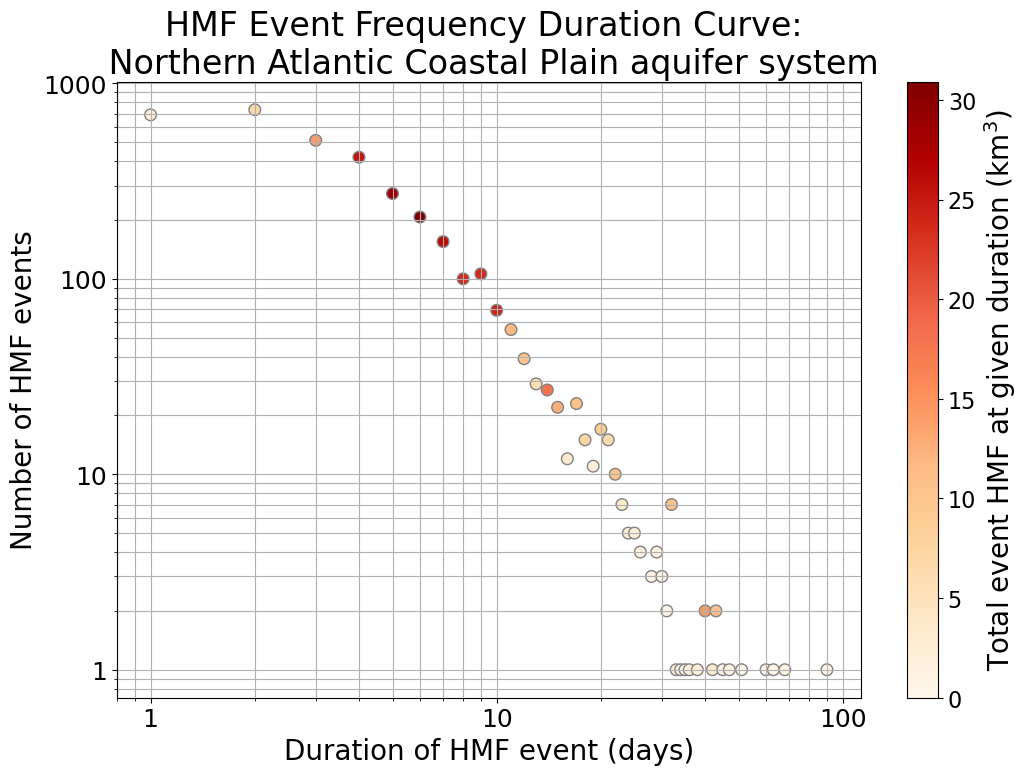

In [195]:
# All aquifers
date_range = '30'
percentile = '90'
aq_events = aq_events_grouped_dict[f'{date_range}_{percentile}']
for aq in aq_codes:
    df = aq_events[aq]
    fdc_events(df, aq)

In [22]:
aq_list_10 = ['High Plains aquifer',
                'Mississippi River Valley alluvial aquifer',
                'Central Valley aquifer system',
                'Basin and Range basin-fill aquifers',
                'Floridan aquifer system',
                'Snake River Plain basaltic-rock aquifers',
                'Coastal lowlands aquifer system',
                'California Coastal Basin aquifers', 
                'Pacific Northwest basin-fill aquifers',
                'Northern Atlantic Coastal Plain aquifer system']

In [75]:
import matplotlib.ticker as mticker

def fdc_events(df, i):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    cm = plt.cm.get_cmap('OrRd')
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=20)
    ax.set_ylabel('Number of HMF events', fontsize=20)
    ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq_list_10[i]}', fontsize=24)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/fdc_{aq}.png'
    fn.save_plot_as_image(img_path, overwrite=True) 

    plt.show()
    
for i, aq in enumerate(aq_codes):
    df = combined_events_by_aq_dict[aq]
    fdc_events(df, i)

NameError: name 'combined_events_by_aq_dict' is not defined

## Annual metrics timeseries for valid gages

In [22]:
import pyarrow.parquet as pq
annual_metrics_df = pq.read_table('Prelim_Data/annual_metrics_subdf_30_90.parquet')

In [25]:
annual_metrics_df = annual_metrics_df.to_pandas()

In [26]:
annual_metrics_df

AttributeError: 'NoneType' object has no attribute 'items'

     site_no  water_year  annual_hmf  annual_duration  event_hmf  \
0   02342500        1990    0.092031             29.0   0.010226   
1   02342500        1991    0.067863             37.0   0.009695   
2   02342500        1992    0.125069             56.0   0.007817   
3   02342500        1993    0.164619             42.0   0.016462   
4   02342500        1994    0.048014             23.0   0.006002   
..       ...         ...         ...              ...        ...   
25  13018300        2015    0.000051             14.0   0.000013   
26  13018300        2016    0.007294             77.0   0.007294   
27  13018300        2017    0.003553             56.0   0.003553   
28  13018300        2018    0.001694             46.0   0.000847   
29  13018300        2019    0.001353             35.0   0.000338   

    event_duration  total_events  timing  
0         3.222222           9.0   181.0  
1         5.285714           7.0   137.0  
2         3.500000          16.0    58.0  
3         4

In [52]:
gage_no = 11447650
df_gage = annual_metrics_df[annual_metrics_df['site_no'] == str(gage_no)]
cols = ['annual_hmf', 'annual_duration', 'event_hmf', 'event_duration', 'total_events', 'timing']
for col in cols:
    value = df_gage[df_gage[col] != 0][col].mean()
    print(col, round(value, 7))

annual_hmf 2.6324419
annual_duration 54.6
event_hmf 1.0337324
event_duration 20.7608333
total_events 2.7
timing 144.6


In [53]:
df_30_90 = dfs_valid['30_90']
df_30_90[df_30_90['site_no'] == gage_no].transpose()
#df_30_90[df_30_90['site_no'] == '13335050']
#dfs_valid['30_90'][dfs_valid['30_90'][['site_no'] == '11447650']]

AttributeError: 'NoneType' object has no attribute 'items'

                                           784
site_no                               11447650
analyze_start              1990-10-01 00:00:00
analyze_end                2020-09-30 00:00:00
analyze_range                               30
quantile                                   0.9
valid                                     True
missing_data%                                0
threshold                                48800
hmf_years                                   20
annual_hmf                             2.63244
six_mo_hmf                             2.44089
three_mo_hmf                           1.37305
annual_duration                           54.6
event_duration                         20.7608
event_hmf                              1.03373
inter_annual%                           66.667
intra_annual                               2.7
timing                                   144.6
jan_hmf                               0.634699
feb_hmf                                1.18156
mar_hmf      